In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy.ndimage as filters 
from sklearn import svm
import scipy
import math
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def get_gradient(img):
    dx = scipy.ndimage.convolve1d(np.int32(img), np.array([-1, 0,
1]),1)
    dy = scipy.ndimage.convolve1d(np.int32(img), np.array([-1, 0,
1]),0)
    grad_amp = np.sqrt(dx**2 + dy**2)
    grad_amp /= np.max(grad_amp)
    grad_orient = np.arctan2(dy, dx)
    return grad_amp, grad_orient


def get_gradient_rgb(img):
    grad_ampB, grad_orientB = get_gradient(img[:, :, 2])
    grad_ampG, grad_orientG = get_gradient(img[:, :, 1])
    grad_ampR, grad_orientR = get_gradient(img[:, :, 0])


    grad_amp_res = grad_ampB.copy()  
    grad_orient_res = grad_orientB.copy()

    maxBG = grad_ampB - grad_ampG  
    grad_amp_res[maxBG < 0] = grad_ampG[maxBG < 0]  
    maxBGR = grad_amp_res - grad_ampR
    grad_amp_res[maxBGR < 0] = grad_ampR[maxBGR < 0]

    grad_orient_res[maxBG < 0] = grad_orientG[maxBG < 0]
    grad_orient_res[maxBGR < 0] = grad_orientR[maxBGR < 0]
    return grad_amp_res, grad_orient_res


def get_histogram(img):
    cellSize = 8

    YY, XX, CH = img.shape
    YY_cell = np.int32(YY/cellSize)
    XX_cell = np.int32(XX/cellSize)

    grad_amp, grad_orient = get_gradient_rgb(img)
    grad_orient = np.rad2deg(grad_orient)

    hists = np.zeros([YY_cell, XX_cell, 9])
    for y in range(YY_cell):
        for x in range(XX_cell):
            grad_cell = grad_amp[y*cellSize: (y+1)*cellSize, x*cellSize: (x+1)*cellSize]
            grad_cell = grad_cell.flatten()

            orient_cell = grad_orient[y*cellSize: (y+1)*cellSize, x*cellSize: (x+1)*cellSize]
            orient_cell = orient_cell.flatten()

            for z in range(len(orient_cell)):
                if orient_cell[z] < 0:
                    orient_cell[z] += 180

                section_middle = (((orient_cell[z] - 10) // 20) * 20 + 10) % 180
                section_idx = ((orient_cell[z] - 10) // 20) % 9

                distance_to_middle = min(abs(orient_cell[z] - section_middle), 180 - abs(orient_cell[z] - section_middle))/20

                hists[y, x, int(section_idx)] += grad_cell[z]*(1-distance_to_middle)
                hists[y, x, int((section_idx + 1) % 9)] += grad_cell[z]*distance_to_middle


    e = math.pow(0.00001,2)
    F = []
    for jj in range(0,YY_cell-1):
        for ii in range(0,XX_cell-1):
            H0 = hists[jj,ii,:]
            H1 = hists[jj,ii+1,:]
            H2 = hists[jj+1,ii,:]
            H3 = hists[jj+1,ii+1,:]
            H = np.concatenate((H0, H1, H2, H3))
            n = np.linalg.norm(H)
            Hn = H/np.sqrt(math.pow(n,2)+e)
            F = np.concatenate((F,Hn))

    return F

TEST

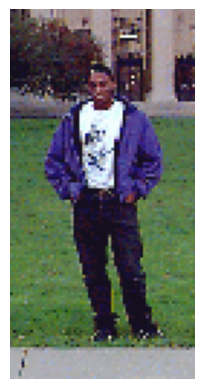

3780
[0.32628489 0.14102181 0.10160697 0.1283148  0.14753034 0.09760302
 0.09749844 0.19737593 0.22033072 0.16186012]


In [3]:
test_img = cv2.imread('pos/per00060.ppm')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.axis('off')
plt.show()

F_vector = get_histogram(test_img)
print(len(F_vector))
print(F_vector[:10])

In [4]:

# Training set
HOG_data = np.zeros([2*100,3781],np.float32)

for i in range(0, 100):
    IP = cv2.imread('pos/per%05d.ppm' % (i+1))
    IN = cv2.imread('neg/neg%05d.png' % (i+1))
    F = get_histogram(IP)
    HOG_data[i,0] = 1
    HOG_data[i,1:] = F
    F = get_histogram(IN)
    HOG_data[i+100,0] = 0
    HOG_data[i+100,1:] = F


# Validation set
HOG_data_val = np.zeros([2*100,3781],np.float32)

for i in range(100, 200):
    IP = cv2.imread('pos/per%05d.ppm' % (i+1))
    IN = cv2.imread('neg/neg%05d.png' % (i+1))
    F = get_histogram(IP)
    HOG_data_val[i-100,0] = 1
    HOG_data_val[i-100,1:] = F
    F = get_histogram(IN)
    HOG_data_val[i,0] = 0
    HOG_data_val[i,1:] = F

labels = HOG_data[:,0]
data = HOG_data[:,1:]
clf = svm.SVC(kernel='linear', C=1)
clf.fit(data, labels)
lp = clf.predict(data)
lp

labels_val = HOG_data_val[:,0]
data_val = HOG_data_val[:,1:]
val_res = clf.predict(data_val)
val_res

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [5]:
print(classification_report(labels, lp))
print(confusion_matrix(labels, lp))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

[[100   0]
 [  0 100]]


In [6]:
print(classification_report(labels_val, val_res))
print(confusion_matrix(labels_val, val_res))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       100
         1.0       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200

[[ 99   1]
 [  0 100]]


In [7]:
def detect_pose(img_path=None, fx=0.5, fy=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, None, fx=fx, fy=fy)
    img_copy = img.copy()
    
    for i in range(0, int(img.shape[1]-64), 8):
        for j in range(0, int(img.shape[0]-128), 8):
            slice = img[j:j+128, i:i+64]
            F = get_histogram(slice)
            lp = clf.predict(F.reshape((1, -1)))
            if lp:
                cv2.rectangle(img_copy, (i, j), (i+64, j+128), (0, 0, 255), 2)
    plt.imshow(img_copy)
    plt.show()

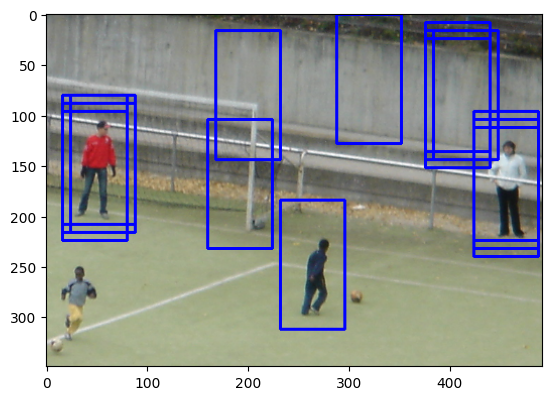

In [8]:
detect_pose('testImage1.png', fx=0.7, fy=0.7)

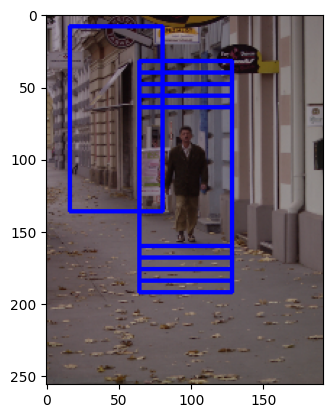

In [9]:
detect_pose('testImage2.png', fx=0.4, fy=0.4)

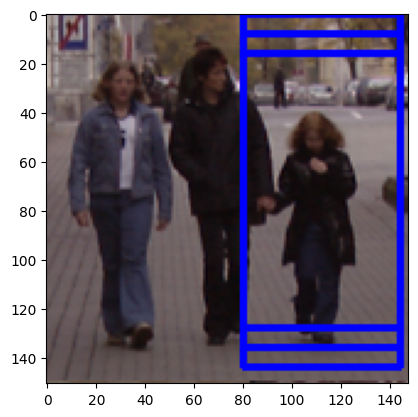

In [10]:
detect_pose('testImage3.png', fx=1, fy=1)

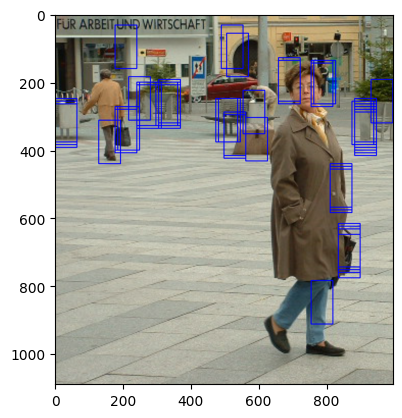

In [11]:
detect_pose('testImage4.png', fx=3, fy=3)